In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class WeatherPreprocessor:
    def __init__(self):
        # Initial weather features for bike usage
        self.weather_features = [
            "Température de l'air",
            "Humidité relative",
            "Visibilité horizontale",
            "Vitesse du vent",
            "Précipitations horaires",
            "Petite_pluie",
            "Grosse_pluie",
            "Indice_ressenti"
        ]


    def merge_with_bike_data(self, bike_df, weather_df):
        """Merge weather data with bike count data"""

        # Round both datetime columns to hours for merging
        bike_df = bike_df.copy()
        bike_df['date'] = pd.to_datetime(bike_df['date']).dt.floor('h')
        weather_df['date'] = weather_df['date'].dt.floor('h')

        # Merge datasets
        merged_df = pd.merge(
            bike_df,
            weather_df,
            on='date',
            how='left'
        )

        return merged_df

def prepare_features_with_weather(bike_df, weather_df):
    """Prepare complete feature set with weather data"""
    # Initialize preprocessor
    preprocessor = WeatherPreprocessor()

    # Merge and preprocess data
    final_df = preprocessor.merge_with_bike_data(bike_df, weather_df)

    # Select features for modeling
    weather_features = [
        "Température de l'air",
        "Humidité relative",
        "Visibilité horizontale",
        "Vitesse du vent",
        "Précipitations horaires",
        "Petite_pluie",
        "Grosse_pluie",
        "Indice_ressenti"
    ]

    return final_df, weather_features

In [ ]:
# Lire le fichier parquet
df = pd.read_parquet(Path("../../data/train.parquet"))


def clean_and_engineer_features(df):
    """
    Clean dataset by removing redundant columns and engineer cyclical features

    Args:
        df: pandas DataFrame containing the bike count data
    Returns:
        DataFrame with cleaned and engineered features
    """
    ## add holidays info
    holidays = pd.read_csv(Path("../Holidays/Propre_jours_feries.csv"))
    holidays['date'] = pd.to_datetime(holidays['date'])
    df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.day_name()
    df['is_weekend'] = df['date'].dt.weekday >= 5
    # Create working day feature
    df['is_working_day'] = (~df['is_weekend']) & (~df['is_holiday'])

    # Create rush hour feature (only for working days)
    morning_rush = (df['hour'].between(7, 9)) & df['is_working_day']
    evening_rush = (df['hour'].between(16, 18)) & df['is_working_day']

    # Add rush hour binary feature
    df['is_rush_hour'] = (morning_rush | evening_rush).astype(int)

    # Columns to drop
    columns_to_drop = [
        'counter_id',
        'site_id',
        'counter_technical_id',
        'counter_installation_date',
        'coordinates',
        'weekday',  # redundant with day_of_week
        'site_name'  # redundant with counter_name
    ]

    # Drop columns if they exist
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    df = df.drop(columns=existing_columns)

    # Add cyclical encoding for hour (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Add cyclical encoding for month (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Add cyclical encoding for day_of_week (7-day cycle)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

    return df

df = clean_and_engineer_features(df)

#bike_df = df
weather_df = pd.read_csv('Propre_meteo.csv')

weather_df['date'] = pd.to_datetime(weather_df['date'])

# Prepare features
final_df, weather_features = prepare_features_with_weather(df, weather_df)
print(weather_features)
final_df.head()

["Température de l'air", 'Humidité relative', 'Visibilité horizontale', 'Vitesse du vent', 'Précipitations horaires', 'Petite_pluie', 'Grosse_pluie', 'Indice_ressenti']


,counter_name,bike_count,date,latitude,longitude,log_bike_count,is_holiday,hour,day_of_week,month,...,day_of_week_sin,day_of_week_cos,Température de l'air,Humidité relative,Visibilité horizontale,Vitesse du vent,Précipitations horaires,Petite_pluie,Grosse_pluie,Indice_ressenti
0,28 boulevard Diderot E-O,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,False,2,1,9,...,0.781831,0.62349,12.75,81.0,30000.0,1.6,0.0,0,0,15.47
1,28 boulevard Diderot E-O,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,False,3,1,9,...,0.781831,0.62349,10.95,88.0,25000.0,1.1,0.0,0,0,15.22
2,28 boulevard Diderot E-O,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,False,4,1,9,...,0.781831,0.62349,10.95,88.0,25000.0,1.1,0.0,0,0,15.22
3,28 boulevard Diderot E-O,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,False,15,1,9,...,0.781831,0.62349,20.65,41.0,30000.0,4.0,0.0,0,0,14.65
4,28 boulevard Diderot E-O,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,False,18,1,9,...,0.781831,0.62349,19.15,47.0,30000.0,3.0,0.0,0,0,14.65


In [15]:
final_df.dtypes

counter_name                     category
bike_count                        float64
date                       datetime64[us]
latitude                          float64
longitude                         float64
log_bike_count                    float64
is_holiday                           bool
hour                                int32
day_of_week                         int32
month                               int32
is_weekend                           bool
is_working_day                       bool
is_rush_hour                        int64
hour_sin                          float64
hour_cos                          float64
month_sin                         float64
month_cos                         float64
day_of_week_sin                   float64
day_of_week_cos                   float64
Température de l'air              float64
Humidité relative                 float64
Visibilité horizontale            float64
Vitesse du vent                   float64
Précipitations horaires           

C:\Users\alexa\AppData\Local\Temp\ipykernel_16124\1276467560.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features,


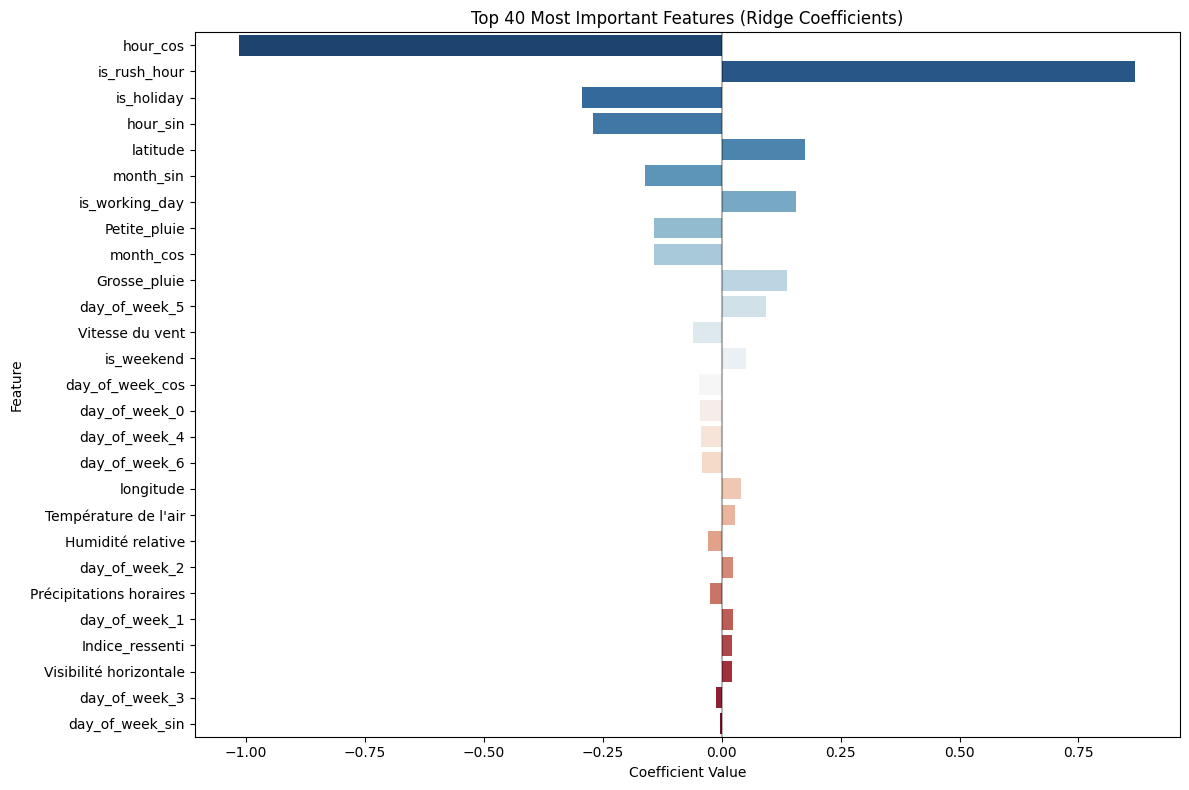

In [ ]:
class RidgeFeatureAnalyzer:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            'day_of_week_sin',
            'day_of_week_cos',
            "Température de l'air",
            "Humidité relative",
            "Visibilité horizontale",
            "Vitesse du vent",
            "Précipitations horaires",
            "Indice_ressenti"

        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_working_day',
            'is_rush_hour',
            'Petite_pluie',
            'Grosse_pluie',
        ]

        self.categorical_features = [
            'counter_name',
            'day_of_week'
        ]

    def create_pipeline(self, alpha=1.0):
        """Create preprocessing and Ridge pipeline"""
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=alpha))
        ])

    def analyze_feature_importance(self, X, y, alpha=1.0):
        """Analyze feature importance using Ridge regression"""
        # Fit pipeline
        pipeline = self.create_pipeline(alpha=alpha)
        pipeline.fit(X, y)

        # Get feature names after preprocessing
        feature_names = (
            self.numeric_features +
            pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['onehot']
            .get_feature_names_out(self.categorical_features).tolist() +
            self.binary_features
        )

        # Get coefficients
        coefficients = pipeline.named_steps['regressor'].coef_

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        })

        # Sort by absolute coefficient value
        importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

        return importance_df

    def plot_feature_importance(self, importance_df, top_n=40):
        """Plot feature importance"""
        plt.figure(figsize=(12, 8))

        # Plot top N features
        top_features = importance_df[~importance_df['feature'].str.contains('counter_name')].head(top_n)

        # Create bar plot
        sns.barplot(data=top_features,
                   y='feature',
                   x='coefficient',
                   palette='RdBu_r')

        plt.title(f'Top {top_n} Most Important Features (Ridge Coefficients)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Define feature groups
numeric_features = [
    'latitude',
    'longitude',
    'hour_sin',
    'hour_cos',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    "Température de l'air",
    "Humidité relative",
    "Visibilité horizontale",
    "Vitesse du vent",
    "Précipitations horaires",
    "Indice_ressenti"
]

# Binary features don't need encoding
binary_features = [
    'is_weekend',
    'is_holiday',
    'is_working_day',
    'is_rush_hour',
    'Petite_pluie',
    'Grosse_pluie',
    ]

# Categorical features need one-hot encoding
categorical_features = [
    'counter_name',
    'day_of_week'  # both cyclic and categorical representation
]

X = final_df[numeric_features + categorical_features + binary_features]
y = final_df['log_bike_count']

analyzer = RidgeFeatureAnalyzer()

# Basic feature importance analysis
importance_df = analyzer.analyze_feature_importance(X, y, alpha=1.0)
analyzer.plot_feature_importance(importance_df)

In [ ]:
def create_ridge_poly_gridsearch(X, y, analyzer):
    """Create and run grid search for Ridge model with polynomial features"""

    # Create preprocessor with polynomial features for numeric features
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, analyzer.numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         analyzer.categorical_features),
        ('bin', 'passthrough', analyzer.binary_features)
    ])

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ])

    # Define parameter grid
    param_grid = {
        'preprocessor__num__poly__degree': [1, 2],
        'regressor__alpha': [100.0],
        'regressor__fit_intercept': [True]
    }

    # Create time series split
    tscv = TimeSeriesSplit(n_splits=5)

    # Create grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    # Fit grid search
    print("Starting grid search...")
    grid_search.fit(X, y)

    # Print results
    print("\nBest parameters:", grid_search.best_params_)
    print(f"Best RMSE: {-grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, pd.DataFrame(grid_search.cv_results_)

In [24]:
# Using existing analyzer instance
best_model_poly, results_poly = create_ridge_poly_gridsearch(X, y, analyzer)

Starting grid search...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best parameters: {'preprocessor__num__poly__degree': 2, 'regressor__alpha': 100.0, 'regressor__fit_intercept': True}
Best RMSE: 1.0615


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

def try_random_forest(X, y, analyzer):
    """Quick test of RandomForest using existing preprocessor"""

    # Create pipeline with same preprocessor but RF instead of Ridge
    pipeline = Pipeline([
        ('preprocessor', analyzer.create_pipeline().named_steps['preprocessor']),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            n_jobs=-1,
            random_state=42
        ))
    ])

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(
        pipeline, X, y,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    rmse_scores = -scores  # Convert back to positive RMSE
    print(f"Mean RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")

    return pipeline, rmse_scores

rf_model, rf_scores = try_random_forest(X, y, analyzer)

Mean RMSE: 0.9840 (+/- 0.2786)
